# Coordinate Descent Inplementation for LASSO 

Following Reference inspired me to replicate his method in Boston Dataset:
https://www.kaggle.com/code/mcweng24/lasso-regression-using-numpy/notebook



*   Load Dataset
*   Initialize Parameters
  * Lasso Cost Function and Partial Derivatives
*   Coordinate Descent Algorithm Intuition
*   Coordinate Descent for --- LASSO
*   Coordinate Descent for --- OLS
*   How our Coordinate LASSO & OLS Performed Compare to Sklearn Package






In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore')

# Load Dataset (Boston)

In [2]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

In [3]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
# standard sclaer
from sklearn.preprocessing import StandardScaler
def std_scaler(X_train,X_test):
  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train_scale=scaler.transform(X_train)
  X_test_scale=scaler.transform(X_test)
  # add a column of 1 for X
  X_train_scale=np.append(np.ones(shape=(X_train.shape[0],1)),X_train_scale,axis=1)
  X_test_scale=np.append(np.ones(shape=(X_test.shape[0],1)),X_test_scale,axis=1)
  return X_train_scale, X_test_scale

X_train,X_test=std_scaler(X_train,X_test)

# Initialize Parameters

In [54]:
 # Set hyperparameters
alpha = 0.2
iterations = 100
tolerance = 0.00001

# Initialize Theta Values to 0
w= np.zeros(X_train.shape[1],dtype=float)


## The LASSO Cost Funnction and it's Partial Derivatives

$$ L(w) = \frac{1}{2N}\left(\sum_{i=1}^n (y^{(i)} - \tilde{w} \cdot \tilde{x}^{(i)})^2\right) + α\left(\sum_{j=1}^d |w_j|\right)= MSE + α * norm |w|$$


* **So, To Minimize the L(w),find the Partial Derivative 𝜕L(w)/𝜕 w Separately**

$$ \frac{𝜕L(w)}{𝜕w_j} = 𝜕 MSE  /  𝜕 w_j  +  𝜕 (α * norm |w| )  /  𝜕 w_j  $$

* **First , 𝜕 MSE  /  𝜕 w_j**

$$ \frac{𝜕 MSE}{𝜕w_j} = \frac{1}{N}\left(\sum_{i=1}^n (-\tilde{x}^{(i)}_j)(y^{(i)} - \left(\sum_{k≠j}^n \tilde{w}_k \cdot \tilde{x}^{(i)}_k\right)) \right) + \frac{1}{N}\tilde{w}_j\left(\sum_{i=1}^n \tilde{x}^{(i)}_j \right)^2 = \frac{-1}{N}ρ_j + \frac{1}{N}\tilde{w}_jz_j    $$

        * Where , ρ_j, z_j defined for simplfying the equation
    
$$ ρ_j = \left(\sum_{i=1}^n (\tilde{x}^{(i)}_j)(y^{(i)} - \left(\sum_{k≠j}^n \tilde{w}_k \cdot \tilde{x}^{(i)}_k\right)) \right)$$

$$ z_j = \left(\sum_{i=1}^n \tilde{x}^{(i)}_j \right)^2$$


* **Secondly , 𝜕 (α * norm |w| )  /  𝜕 w_j**

$$α\frac{𝜕|w_j|}{𝜕w_j} = 
    \begin{cases}
        -α & \text{when $w_j$ < 0}\\
        [-α,α] & \text{when $w_j$ = 0}\\
        α & \text{when $w_j$ > 0}\\
    \end{cases}
$$

* **Put First and Second together and Make it 0, to calculate the w_j**

$$
\frac{𝜕L(w)}{𝜕w_j} = \frac{-1}{N}ρ_j + \frac{1}{N}\tilde{w}_jz_j + 
    \begin{cases}
        -α & \text{when $w_j$ < 0}\\
        [-α,α] & \text{when $w_j$ = 0}\\
        α & \text{when $w_j$ > 0}\\
    \end{cases}=0
$$


* **The w_j Solution**

$$ w_j = 
    \begin{cases}
        \frac{ρ_j + Nα}{z_j} & \text{if $ρ_j$ < -Nα}\\
        0 & \text{if -Nα ≤ $ρ_j$ ≤ Nα }\\
        \frac{ρ_j - Nα}{z_j} & \text{if $ρ_j$ > Nα}\\
    \end{cases}
$$

# Coordinate Descent Algorithm

**1. Pre-compute z_j:**
$$ z_j = \left(\sum_{i=1}^n \tilde{x}^{(i)}_j \right)^2$$
          * z_j = np.dot(X_j,X_j)

**2. Initialise the $\tilde{w}$ to be a zero vector**

          * w= np.zeros(X_train.shape[1],dtype=float)

**3. Initialise the maximum step parameter and tolerance level**

**4. While the algorithm has not converged**

> For j = 0,1,...,D
>> Compute:

$$ ρ_j = \left(\sum_{i=1}^n (\tilde{x}^{(i)}_j)(y^{(i)} - \left(\sum_{k≠j}^n \tilde{w}_k \cdot \tilde{x}^{(i)}_k\right)) \right)$$

        * rho_j = np.dot(X_j,residual)
        * residual = y - np.matmul(X_k, w_k.T)

>> If j = 0
$$ w_j = \frac{ρ_j}{z_j}$$
>> Else
$$ w_j = 
    \begin{cases}
        \frac{ρ_j + Nα}{z_j} & \text{if $ρ_j$ < -Nα}\\
        0 & \text{if -Nα ≤ $ρ_j$ ≤ Nα }\\
        \frac{ρ_j - Nα}{z_j} & \text{if $ρ_j$ > Nα}\\
    \end{cases}
$$

      * N, d = X_train.shape
        * N = num of points
        * d = num of features

# Sub Functions to Implement Coordinate Descent

* cost function
* rho_j
* z_j
* coordinate_descent

# Coordinate Descent for LASSO

In [55]:
# function for: define cost function ; calculate the gradient
## alpha = shrinkage factor
def cost_function_lasso(X,w,y,alpha):
  n=y.size
  y_pred=np.matmul(X,w.T)
  error=y_pred-y
  theta_norm=LA.norm(w,ord=1)
  cost = np.dot(error.T, error)+alpha*theta_norm
  return cost

In [56]:
def compute_rho_j(X,y,w,j):
  X_k = np.delete(X,j,axis=1) #Remove the j variable i.e. j column
  w_k = np.delete(w,j) #Remove the weight j
  predict = np.matmul(X_k, w_k.T)
  residual = y - predict
  X_j=X[:,j] # m*1 vector
  rho_j = np.dot(X_j,residual)
  return(rho_j)

In [57]:
#z computation for unnormalised features
def compute_z_j(X,j):
  X_j=X[:,j]
  z_j = np.dot(X_j,X_j) #Compute sum for each column
  return(z_j)

In [58]:
def coordinate_descent_lasso(y,X,w,alpha,tolerance):
    max_step = 100.
    iteration = 0
    N,d=X.shape # N=num of point ; d=num of features
    cost_diff=1
    cost_array={}
    while(cost_diff > tolerance):
        iteration += 1
        #print("Iteration (start) : ",iteration)
        cost_old=cost_function_lasso(X,w,y,alpha)

        for j in range(d): #Take the number of features ie columns
            rho_j = compute_rho_j(X,y,w,j)
            z_j=compute_z_j(X,j)
            if j == 0: #Intercept is not included with the alpha regularisation
                w[j] = rho_j/z_j
            elif rho_j < -alpha*N:
                w[j] = (rho_j + (alpha*N))/z_j
            elif rho_j > -alpha*N and rho_j < alpha*N:
                w[j] = 0
            elif rho_j > alpha*N:
                w[j] = (rho_j - (alpha*N))/z_j
            else:
                w[j] = np.NaN
        # update the cost function
        cost_new=cost_function_lasso(X,w,y,alpha)
        cost_array[iteration]=cost_new
        cost_diff=abs(cost_new-cost_old)
        
    print(w)
    return w, iteration, cost_array

In [59]:
# run the coordinate descent for our train set
w_cd_lasso,iter_lasso,cost_array_lasso=coordinate_descent_lasso(y_train,X_train,w,alpha,tolerance)

[22.97079646 -0.39948163  0.1892843   0.          0.82759114 -0.80309358
  2.93205242  0.         -1.5002346   0.          0.         -1.70669261
  0.83142358 -4.01081814]


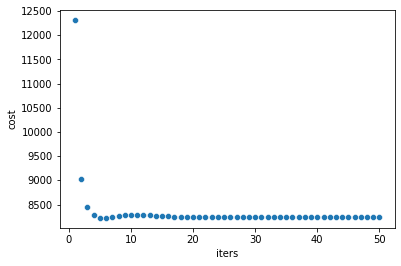

In [60]:
# function for: display the cost-iter trend
def plot_cost_iter(cost_array):
  iters=cost_array.keys()
  cost=cost_array.values()
  fig=sns.scatterplot(x=iters,y=cost)
  fig.set_xlabel('iters')
  fig.set_ylabel('cost')
  return fig

# display
fig_lasso=plot_cost_iter(cost_array_lasso)
fig_lasso

# Coordinate Descent for OLS (Ordinary Least Squares)

* **For OLS , 𝜕 L(w)  /  𝜕 w_j**

$$ \frac{𝜕 L}{𝜕w_j} = \frac{1}{N}\left(\sum_{i=1}^n (-\tilde{x}^{(i)}_j)(y^{(i)} - \left(\sum_{k≠j}^n \tilde{w}_k \cdot \tilde{x}^{(i)}_k\right)) \right) + \frac{1}{N}\tilde{w}_j\left(\sum_{i=1}^n \tilde{x}^{(i)}_j \right)^2 = \frac{-1}{N}ρ_j + \frac{1}{N}\tilde{w}_jz_j    $$

* **So The w_j:**
$$ w_j = \frac{ρ_j}{z_j}$$

In [46]:
# function for: define cost function ; calculate the gradient
def cost_function_ols(X,w,y):
  n=y.size
  y_pred=np.matmul(X,w.T)
  error=y_pred-y
  cost = (0.5*n)*np.dot(error.T, error)
  return cost

In [27]:
def coordinate_descent_ols(y,X,w,tolerance):
    max_step = 500
    iteration = 0
    N,d=X.shape # N=num of point ; d=num of features
    cost_diff=1
    cost_array={}
    while(cost_diff > tolerance):
        iteration += 1
        #print("Iteration (start) : ",iteration)
        cost_old=cost_function_ols(X,w,y)

        for j in range(d): #Take the number of features ie columns
            rho_j = compute_rho_j(X,y,w,j)
            z_j=compute_z_j(X,j)
            w[j] = rho_j/z_j
        
        # update the cost function
        cost_new=cost_function_ols(X,w,y)
        cost_array[iteration]=cost_new
        cost_diff=abs(cost_new-cost_old)
        
    print(w)
    return w, iteration, cost_array

[22.97079646 -0.98856987  0.8679275   0.40501448  0.86184024 -1.90008084
  2.80813738 -0.35866919 -3.0455284   2.0327132  -1.36397513 -2.08252829
  1.04125563 -3.9262893 ]


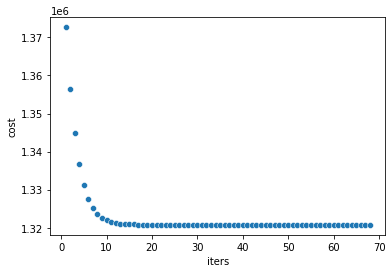

In [61]:
# run the coordinate descent for our train set
w_cd_ols,iter_ols,cost_array_ols=coordinate_descent_ols(y_train,X_train,w,tolerance)

# display
fig_ols=plot_cost_iter(cost_array_ols)
fig_ols

# Model Performance on Test Dataset  --- 4 Models Compare (ours and scikit package)



1.   (Own) Coordinate descent Lasso
2.   Scikit Lasso
3.   (Own) Coordinate descent OLS
4.   Scikit OLS



In [62]:
# scatterplot the y_pred and y_actual, display the MSE, theta
def plot_pred_actual(w,X_test,y_test):
  num_of_pt=y_test.size
  y_test_pred=np.matmul(X_test,w.T)
  mse=mean_squared_error(y_test,y_test_pred)
  # plot the graph
  fig, ax1 = plt.subplots(1,1,constrained_layout=True)
  sns.scatterplot(x=y_test_pred,y=y_test,ax=ax1)
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints, linestyle='--', color='k')
  ax1.set_xlabel('y_pred')
  ax1.set_ylabel('y_actual')
  ax1.text(0,0.92,f'The MSE = {mse}',transform=ax1.transAxes)
  ax1.text(0,0.85,f'The num of Point = {num_of_pt}',transform=ax1.transAxes)
  return mse

## 1. Our Coodinate Descent Lasso

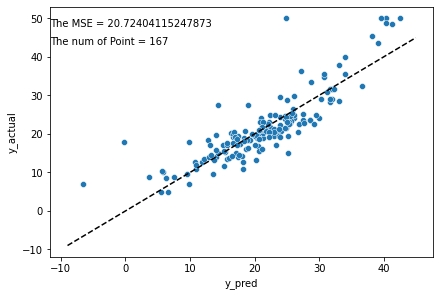

In [66]:
mse_cd_lasso_test=plot_pred_actual(w=w_cd_lasso,
                 X_test=X_test,
                 y_test=y_test)

## 2. Scikit Lasso

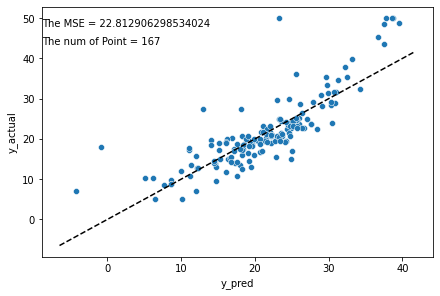

In [67]:
from sklearn.linear_model import Lasso

# fit the lasso
sk_lasso=Lasso(alpha,fit_intercept=False)
sk_lasso.fit(X_train,y_train)
w_lasso=sk_lasso.coef_

# test set result
mse_sk_lasso_test=plot_pred_actual(w_lasso,X_test,y_test)

## 3. Our Coordinate Descent OLS

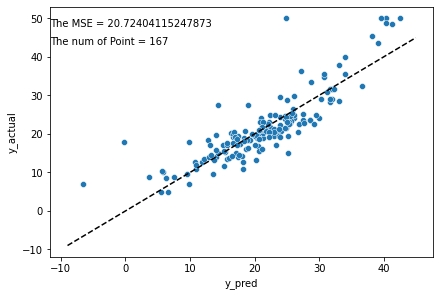

In [68]:
mse_cd_ols_test=plot_pred_actual(w=w_cd_ols,
                 X_test=X_test,
                 y_test=y_test)

## 4. Scikit OLS

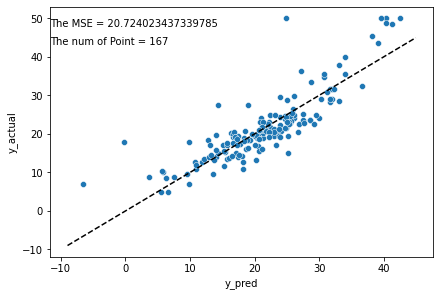

In [69]:
from sklearn.linear_model import LinearRegression

# fit the lasso
sk_ols=LinearRegression(fit_intercept=False)
sk_ols.fit(X_train,y_train)
w_ols=sk_ols.coef_

# test set result
mse_sk_ols_test=plot_pred_actual(w_ols,X_test,y_test)

## Models MSE Compare

-  Coordinate Descent LASSO  =  20.72404115247873
-  Scikit LASSO  =  22.812906298534024
-  Coordinate Descent OLS  =  20.72404115247873
-  Scikit OLS  =  20.724023437339785


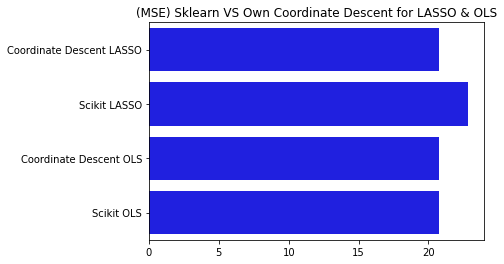

In [79]:
# compare the mse for our gradient descent regression VS sklearn package
x=[mse_cd_lasso_test,mse_sk_lasso_test,mse_cd_ols_test,mse_sk_ols_test]
y=['Coordinate Descent LASSO','Scikit LASSO','Coordinate Descent OLS','Scikit OLS']
fig=sns.barplot(x=x,y=y,color='blue')
fig.set_title('(MSE) Sklearn VS Own Coordinate Descent for LASSO & OLS')
for mse,model in zip(x,y):
  print('- ',model, ' = ',mse)

### OLS genrally has better MSE than LASSO (Possible Reason: The data quality is high)

## Model Weights Compare (w)

In [83]:
def plot_w(w,model_name):
  fig=sns.barplot(x=w,y=[str(i) for i in range(14)])
  fig.set_title(f'{model_name} Weight Value')
  plt.show()
  return w

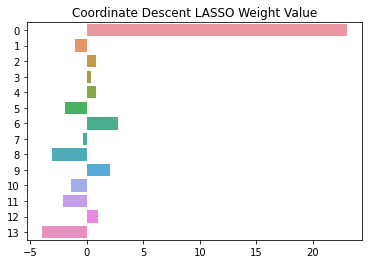

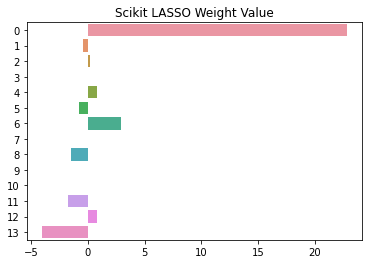

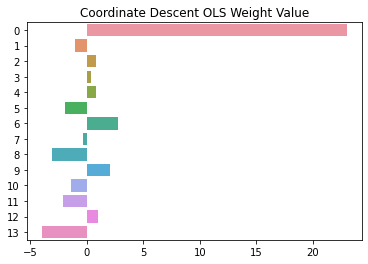

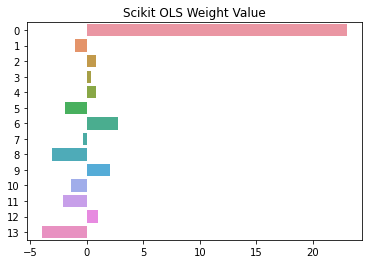

In [84]:
w_list=[w_cd_lasso,w_lasso,w_cd_ols,w_ols]
model_name_list=['Coordinate Descent LASSO','Scikit LASSO','Coordinate Descent OLS','Scikit OLS']

for w, model_name in zip(w_list,model_name_list):
  plot_w(w,model_name)